In [2]:
import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy.integrate import quad
import matplotlib.pyplot as plt
from functools import partial
import time

<a id='sec2'></a>
# Heston model

The Heston process is described by the SDE: 

$$ \begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t 
\end{cases}$$

The stock price follows a "geometric Brownian motion" with a stochastic volatility. The square of the volatility (the variance) follows a CIR process.     


The parameters are:
- $\mu$ drift of the stock process
- $\kappa$ mean reversion coefficient of the variance process
- $\theta$ long term mean of the variance process 
- $\sigma$  volatility coefficient of the variance process
- $\rho$ correlation between $W^1$ and $W^2$ i.e.
$$ dW^1_t dW^2_t = \rho dt $$

We will also require that $2\kappa \theta > \sigma^2$ (Feller condition).

In the Heston Model, we have:

\begin{align}
C(t\,,{{S}_{t}},{{v}_{t}},K,T)={{S}_{t}}{{P}_{1}}-K\,{{e}^{-r\tau }}{{P}_{2}}
\end{align}


where, for j=1,2


\begin{align}
& {{P}_{j}}({{x}_{t}}\,,\,{{v}_{t}}\,;\,\,{{x}_{T}},\ln K)=\frac{1}{2}+\frac{1}{\pi }\int\limits_{0}^{\infty }{\operatorname{Re}\left( \frac{{{e}^{-i\phi \ln K}}{{f}_{j}}(\phi ;t,x,v)}{i\phi } \right)}\,d\phi  \\ 
 & {{f}_{j}}(\phi \,;{{v}_{t}},{{x}_{t}})=\exp [{{C}_{j}}(\tau ,\phi )+{{D}_{j}}(\tau ,\phi ){{v}_{t}}+i\phi {{x}_{t}}] \\ 
\end{align}

and

\begin{align}
  & {{C}_{j}}(\tau ,\phi )=(r-q)i\phi \,\tau +\frac{a}{{{\sigma }^{2}}}{{\left( ({{b}_{j}}-\rho \sigma i\phi +{{d}_{j}})\,\tau -2\ln \frac{1-{{g}_{j}}{{e}^{{{d}_{j}}\tau }}}{1-{{g}_{j}}} \right)}_{_{_{_{{}}}}}} \\ 
   & {{D}_{j}}(\tau ,\phi )=\frac{{{b}_{j}}-\rho \sigma i\phi +{{d}_{j}}}{{{\sigma }^{2}}}\left( \frac{1-{{e}^{{{d}_{j}}\tau }}}{1-{{g}_{j}}{{e}^{{{d}_{j}}\tau }}} \right) \\ 
\end{align}


where

\begin{align}
  & {{g}_{j}}=\frac{{{b}_{j}}-\rho \sigma i\phi +{{d}_{j}}}{{{b}_{j}}-\rho \sigma i\phi -{{d}_{j}}} \\ 
 & {{d}_{j}}=\sqrt{{{({{b}_{j}}-\rho \sigma i\phi )}^{2}}-{{\sigma }^{2}}(2i{{u}_{j}}\phi -{{\phi }^{2}})} \\ 
 & {{u}_{1}}=\frac{1}{2}\,,\,{{u}_{2}}=-\frac{1}{2}\,,\,a=\kappa \theta \,,\,{{b}_{1}}=\kappa +\lambda -\rho \sigma \,,\,{{b}_{2}}=\kappa +\lambda \,,\ {{i}^{2}}=-1 \\ 
\end{align}

In [3]:
r = 0.01 # drift
rho = -0.4 # correlation coefficient
kappa = 3 # mean reversion coefficient
theta = 0.06 # long-term mean of the variance
sigma = 0.1 # (Vol of Vol) - Volatility of instantaneous variance
T = 1 # Terminal time
K = 100 # Stike
v0 = 0.07 # spot variance (initial variance)
s0 = 115 # spot stock price
k = np.log(K/s0)


In [4]:
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi+d)*t - 2*np.log( (1-g1*np.exp(d*t))/(1-g1) ))\
              + (v0/sigma**2)*(xi+d) * (1-np.exp(d*t))/(1-g1*np.exp(d*t)) )
    return cf


In [5]:
def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    g2 = 1/g1
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
              + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
    return cf

In [6]:
def Q1(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the stock numeraire.
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( (np.exp(-u*k*1j) / (u*1j)) * 
                                  cf(u-1j) / cf(-1.0000000000001j) )  
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]

In [7]:
def Q2(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the money market numeraire
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) )
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]

In [8]:
def fourier_call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):               
    cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho )  
    limit_max = 2000               
    return s0 * Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r*T) * Q2(k, cf_H_b_good, limit_max)

In [9]:
def fourier_put_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):              
    cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho )  
    limit_max = 2000              
    return K * np.exp(-r*T) * (1 - Q2(k, cf_H_b_good, limit_max)) - s0 * Q1(k, cf_H_b_good, limit_max)

In [10]:
t1 = time.time()
for i in range(10):
    print("Heston Fourier inversion call price: ", fourier_call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K))
    print("Heston Fourier inversion put price: ", fourier_put_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K))
print (time.time()-t1)

Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -57.39053690630631
Heston Fourier inversion call price:  20.596981633580626
Heston Fourier inversion put price:  -5

### SIMULATION


In [11]:
import csv

Reasonable ranges to randomly generate Heston model parameters!!!!!

In [12]:
#numpy.arange([start, ]stop, [step, ], dtype=None) -> numpy.ndarray

Kappa=  np.arange(2,4,0.5)                              # mean reversion coefficient
Theta = np.arange(0.02, 0.08, 0.01)                      # long-term mean of the variance
Sigma= np.arange(0.3, 0.8, 0.1)                          # (Vol of Vol) - Volatility of instantaneous variance
Rho = np.arange(-0.5, -0.3, 0.1)                        # correlation coefficient

V0 = np.arange(0.05,0.08,0.01)                                        # spot variance (initial variance)
r = 0.05                                           # drift 

Time = [0.5, 1, 1.5, 2]                               # Terminal time
Stock = np.arange(65, 135, 5)                         # spot stock price 
Strike = [60,70,80,90,100,110,120,130,140]              # Strike  


# To avoid extreme prices - K  will be a multiple of the Stock Price (S) rather than a completely seperate RV
#Strike = np.random.random(len(Stock)) + 0.5

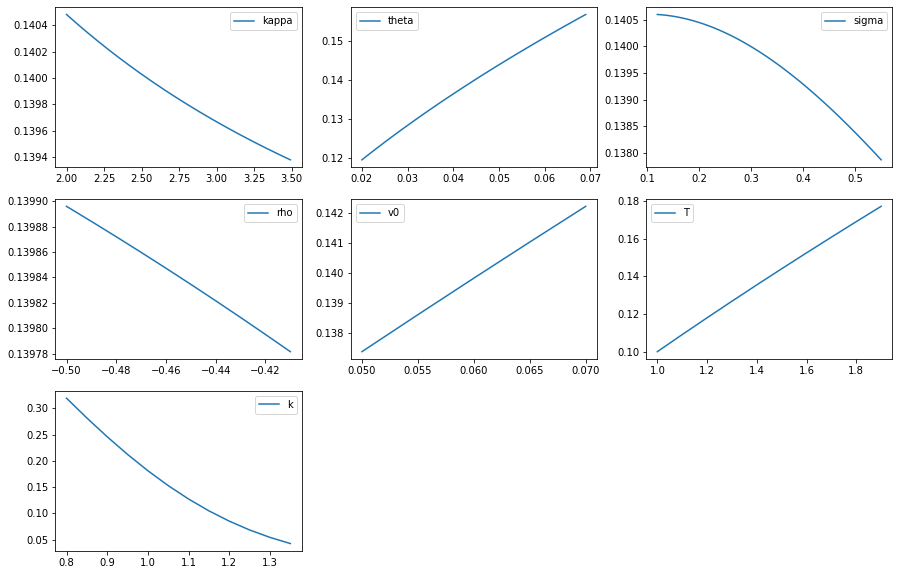

In [15]:
import pandas as pd
import numpy as np
import csv
from heston import fourier_call_price_2

from matplotlib import pyplot as plt

params = {"kappa":np.arange(2, 3.5, 0.01),
          "theta": np.arange(0.02, 0.07, 0.001),
          "sigma": np.arange(0.1, 0.55, 0.01),     
          "rho": np.arange(-0.5, -0.4, 0.01),
          "v0": np.arange(0.05,0.07,0.005), 
          "r": 0.1,
          "T": np.arange(1, 2, 0.1),
          "k": np.arange(0.8, 1.4, 0.05)}

means = {k:np.mean(v) for k,v in params.items()}
index = 1

plt.figure(figsize=(15, 10))
for k, v in params.items():
    if k == "r":
        continue
    X = dict(means)
    x_plot = []
    y_plot = []
    for x in params[k]:
        X[k] = x
        y_plot.append(fourier_call_price_2(**X))
        x_plot.append(list(X.values()))
    
    sub = plt.subplot(3, 3, index)
    plt.plot(params[k], y_plot, label=k)
    sub.legend()
    index += 1  
        
plt.show()

In [21]:
r = 0.1
with open("heston_matteo.csv", mode='w') as f:
    writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for kappa in np.arange(2, 3.5, 0.5):
        for theta in np.arange(0.02, 0.07, 0.01):
            for sigma in np.arange(0.1, 0.5, 0.1):
                for rho in np.arange(-0.5, -0.4, 0.1):
                    for v0 in np.arange(0.05,0.07,0.01):
                        for T in [1, 1.5, 2]:
                            for k in np.arange(0.8, 1.4, 0.05):
                                call_price = fourier_call_price_2(kappa, theta, sigma, rho, v0, r, T, k)
                                writer.writerow([kappa, theta, sigma, rho, v0, r, T, k, call_price])
                                

/Users/sani/tesi_sidorela/heston.py:11: RuntimeWarning: divide by zero encountered in cdouble_scalars
  g1 = (xi+d)/(xi-d)
/Users/sani/tesi_sidorela/heston.py:11: RuntimeWarning: invalid value encountered in cdouble_scalars
  g1 = (xi+d)/(xi-d)
/Users/sani/tesi_sidorela/heston.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]


In [22]:
df = pd.read_csv("heston_matteo.csv")
df.describe()

,2.0,0.02,0.1,-0.5,0.05,0.1.1,1,0.8,0.2794296628469902
count,6479.000000,6479.000000,6479.000000,6479.0,6479.000000,6.479000e+03,6479.000000,6479.000000,5399.000000
mean,2.500077,0.040003,0.250023,-0.5,0.060002,1.000000e-01,1.500077,1.075042,0.157092
std,0.408264,0.014142,0.111805,0.0,0.008165,1.215788e-14,0.408264,0.172595,0.094422
min,2.000000,0.020000,0.100000,-0.5,0.050000,1.000000e-01,1.000000,0.800000,0.006041
25%,2.000000,0.030000,0.200000,-0.5,0.050000,1.000000e-01,1.000000,0.950000,0.076827
50%,2.500000,0.040000,0.300000,-0.5,0.060000,1.000000e-01,1.500000,1.100000,0.142186
75%,3.000000,0.050000,0.350000,-0.5,0.070000,1.000000e-01,2.000000,1.225000,0.237815
max,3.000000,0.060000,0.400000,-0.5,0.070000,1.000000e-01,2.000000,1.350000,0.366034
